In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools as axtools


import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'enrichment_shuffle_svs'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

# Set pbt temp dir

In [2]:
pybedtools_tempdir = private_out + '/temp'

In [4]:
DJ.makedir(pybedtools_tempdir)

In [5]:
pbt.set_tempdir(pybedtools_tempdir)

# Set up parallel engines (to do shuffling/permutations)

In [222]:
# import socket
# if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
#     pbt.set_tempdir(pybedtools_tempdir)

In [10]:
from ipyparallel import Client

In [11]:
parallel_client = Client(profile='parallel-flh2')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

Cluster has 100 engines.


In [12]:
with dview.sync_imports():
    import pybedtools as pbt
    import pandas as pd
    import subprocess
    import os
    import copy
    import numpy
    import scipy

importing pybedtools on engine(s)
importing pandas on engine(s)
importing subprocess on engine(s)
importing os on engine(s)
importing copy on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)


In [13]:
%px pbt = pybedtools
%px pd = pandas
%px np = numpy
%px pbt.set_tempdir('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/temp')

# Make Bed Files For Enrichments

In [14]:
def prep_combined_info(df):
    df = df.copy()
    df['chrom'] = df.Chr
    df['Chr'] = df.Chr.apply(lambda x: 'chr{}'.format(x))
    df['Start'] = df.Start.astype(int)
    df['End'] = df['End'].astype(int)
    df = df[df.SVTYPE != 'Non_Bi']
    
    inds = df[df.Caller == 'GS_LCNV'].index.tolist()
    df.loc[inds, 'SVTYPE_i2QTL_unrel'] = df.loc[inds, 'SVTYPE']
    df.loc[inds, 'SVTYPE_iPSCORE'] = df.loc[inds, 'SVTYPE']
    df.loc[inds, 'SVTYPE_hipsci_fib'] = df.loc[inds, 'SVTYPE']
    df = df[df.MAF_i2QTL_unrel > 0]
    
    inds = df[(df.SVTYPE_i2QTL_unrel == 'mCNV') & (df.NNREF_i2QTL_unrel == 1)].index.tolist()
    df.loc[inds, 'SVTYPE_i2QTL_unrel'] = 'DUP'
    
    df['frequency_category'] = False
    inds = df[df.MAF_i2QTL_unrel > 0.05].index
    df.loc[inds, 'frequency_category'] = 'common'
    
    inds = df[(df.MAF_i2QTL_unrel <= 0.05) & (df.NNREF_i2QTL_unrel > 1)].index
    df.loc[inds, 'frequency_category'] = 'rare'
    
    inds = df[(df.NNREF_i2QTL_unrel == 1) & (df.SVTYPE_i2QTL_unrel != 'mCNV')].index 
    df.loc[inds, 'frequency_category'] = 'singleton'
    
    df['SVTYPE_Freq'] = df.SVTYPE_i2QTL_unrel + '_' + df.frequency_category
    
    return df

def prep_hipstr(df):
    df = df.copy()
    df = df[df.in_vcf==True]
    df['START'] = df.START.astype(int)
    df['END'] = df['END'].astype(int)
    df['NREF_DOSAGE_i2QTL_unrel'] = df['NREF_DOSAGE_i2QTL_unrel'].astype(int)
    df['NREF_FRAC_DOSAGE_i2QTL_unrel'] = df['NREF_FRAC_DOSAGE_i2QTL_unrel'].astype(float)
    df['NREF_DOSAGE_i2QTL_unrel'] = df['NREF_DOSAGE_i2QTL_unrel'].astype(int)
    df = df.sort_values(['CHROM', 'START', 'END'])
    df = df[df['NREF_DOSAGE_i2QTL_unrel'] > 0]
    df['CHROM'] = df['CHROM'].apply(lambda x: 'chr{}'.format(x))
    
    df['frequency_category'] = False
    # common 
    inds = df[df['NREF_FRAC_DOSAGE_i2QTL_unrel'] > 0.05].index
    df.loc[inds, 'frequency_category'] = 'common'
    
    # rare but not singletons
    inds = df[(df['NREF_FRAC_DOSAGE_i2QTL_unrel'] <= 0.05) & (df.NREF_DOSAGE_i2QTL_unrel > 1)].index
    df.loc[inds, 'frequency_category'] = 'rare'

    # singleton variants in i2QTL unrel
    inds = df[(df['NREF_DOSAGE_i2QTL_unrel'] == 1)].index
    df.loc[inds, 'frequency_category'] = 'singleton'
    
    df['SVTYPE_Freq'] = df.SVTYPE + '_' + df.frequency_category
    
    return df


def add_chr(bt):
    """Add 'chr' to chromosomes for BedTool object
    Parameters
    ----------
    bt : pybedtools.BedTool
        BedTool to add 'chr' to.
    Returns
    -------
    out : pybedtools.BedTool
        New BedTool with 'chr' added to chromosome names.
    """
    try:
        df = pd.read_table(bt.fn, header=None, dtype=str)
    # If the try fails, I assume that's because the file has a trackline. Note
    # that I don't preserve the trackline (I'm not sure how pybedtools keeps
    # track of it anyway).
    except pd.parser.CParserError:
        df = pd.read_table(bt.fn, header=None, skiprows=1, dtype=str)
    df[0] = 'chr' + df[0]
    s = '\n'.join(df.astype(str).apply(lambda x: '\t'.join(x), axis=1)) + '\n'
    out = pbt.BedTool(s, from_string=True)
    return out

# Make Single Input Bed with SV/STRs
We will label each SVTYPE and its frequency label for convenience when counting up intersections

In [92]:
bed_output = private_out + '/bed_files_svs'
DJ.makedir(bed_output)

In [153]:
combined_non_redun_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/combine_mc_variant_info/combined_non_redun_info_new.pkl').pipe(prep_combined_info)
# combined_non_redun_info = combined_non_redun_info[combined_non_redun_info.SVTYPE != 'Non_Bi']

In [154]:
cols = ['Chr', 'Start', 'End', 'ID', 'SVTYPE_Freq']

fn_bedtool = os.path.join(bed_output, 'SV_non_redun_all.bed')
bt_sv = pbt.BedTool.from_dataframe(combined_non_redun_info[cols]).moveto(fn_bedtool)

In [31]:
hipstr_combined_annotations = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_final_vcf/hipstr_combined_annotations.pkl').pipe(prep_hipstr)

In [33]:
cols =['CHROM', 'START', 'END', 'ID', 'SVTYPE_Freq']

In [107]:
fn_bedtool = os.path.join(bed_output, 'STR_non_redun_all.bed')
bt_str = pbt.BedTool.from_dataframe(hipstr_combined_annotations[cols]).moveto(fn_bedtool)

In [93]:
fn_bedtool = os.path.join(bed_output, 'STR_non_redun_all.bed')
bt_str = pbt.BedTool(fn_bedtool)

In [155]:
bed_output = private_out + '/bed_files_permutations'
DJ.makedir(bed_output)

In [157]:
## permutation 0 is non-permuted data
fn_bedtool = os.path.join(bed_output, 'vars_all_perm0.bed')
bt_all = bt_sv.cat(bt_str, postmerge=False).sort().moveto(fn_bedtool)

# Number of Vars per Category

In [251]:
vars_per_cat_dict = combined_non_redun_info.SVTYPE_Freq.value_counts().to_dict()

d = hipstr_combined_annotations.SVTYPE_Freq.value_counts().to_dict()

vars_per_cat_dict.update(d)

In [255]:
# vdj = pd.read_table('/frazer01/home/djakubosky/reference_MD/Homo_sapiens_assembly19/Homo_sapiens_assembly19.vdjregions.bed')

# vdj_bt =  pbt.BedTool.from_dataframe(vdj[''])

# Shuffle Beds

In [369]:
lumpy_exclude = '/software/speedseq-20151103/annotations/ceph18.b37.lumpy.exclude.2014-01-15.bed'

fn_lumpy_exclude = private_out + '/lumpy_exclude.bed'
lumpy_bt = add_chr(pbt.BedTool(lumpy_exclude)).moveto(fn_lumpy_exclude)
genome_chroms = ['chr{}'.format(i) for i in range(1,23) + ['X', 'Y']]

In [301]:
genome_hg19 = pd.read_table('/publicdata/gencode_v19_20151104/txdb/hg19.size')
genome_hg19 = genome_hg19.set_index('chrom', drop = False)
genome_hg19 = genome_hg19.loc[genome_chroms]

In [306]:
fn_genome = private_out + '/hg19.txt'
genome_hg19[['chrom', 'length']].to_csv(fn_genome, header = False, index = False, sep = '\t')

In [373]:
bed_output = private_out + '/bed_files_svs'
DJ.makedir(bed_output)

In [332]:
cols = ['Chr', 'Start', 'End', 'ID', 'SVTYPE_Freq']

fn_bedtool = os.path.join(bed_output, 'lumpy_non_redun_all.bed')
bt_lumpy = pbt.BedTool.from_dataframe(combined_non_redun_info[combined_non_redun_info.Caller == 'SS'][cols]).moveto(fn_bedtool)

fn_bedtool = os.path.join(bed_output, 'gs_melt_non_redun_all.bed')
bt_non_lumpy = pbt.BedTool.from_dataframe(combined_non_redun_info[combined_non_redun_info.Caller != 'SS'][cols]).moveto(fn_bedtool)

fn_bedtool = os.path.join(bed_output, 'sv_str_no_lumpy_non_redun_all.bed')
bt_str_non_lumpy = bt_non_lumpy.cat(bt_str, postmerge=False).sort().moveto(fn_bedtool)

# Make Labeled Feature Bed
Bedfile containing genes/exons/promoters with an ID column to label them - this will be used to intersect/avoid multiple intersections to get info for different categories

In [201]:
# feature bedfiles (genes etc)
bed_output = private_out + '/bed_files_features'
DJ.makedir(bed_output)

genes_bed = "/publicdata/gencode_v19_20151104/genes.bed"
exons_bed = "/publicdata/gencode_v19_20151104/exons.bed"
promoters_bed = "/publicdata/gencode_v19_20151104/promoters.bed"

# add identifiers to bed files and cat them together

fn_bedtool_genes =  os.path.join(bed_output, 'genes_id.bed')

! cat /publicdata/gencode_v19_20151104/genes.bed | awk ' { print $0 "\tgene"  } '  > /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_features/genes_id.bed

fn_bedtool_exons =  os.path.join(bed_output, 'exons_id.bed')

! cat /publicdata/gencode_v19_20151104/exons.bed | awk ' { print $0 "\texon"  } '  > /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_features/exons_id.bed

fn_bedtool_promoters =  os.path.join(bed_output, 'promoters_id.bed')

! cat /publicdata/gencode_v19_20151104/promoters.bed | awk ' { print $0 "\tpromoter"  } '  > /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_features/promoters_id.bed

fn_bedtool =  os.path.join(bed_output, 'genic_features_all.bed')

! cat {fn_bedtool_genes} {fn_bedtool_exons} {fn_bedtool_promoters} | sort-bed - > {fn_bedtool}

In [15]:
def perform_shuffle(bt_lumpy, bt_str_non_lumpy, seed = 0, genome = 'hg19', lumpy_exclude = False,
                   bed_output = False):
    
    if bed_output:
        fn_perm = os.path.join(bed_output, 'vars_all_perm{}.bed'.format(seed))
        bt_perm = (bt_lumpy.shuffle(genome = 'hg19', chrom= True, seed = seed, excl= lumpy_exclude)
                   .cat(bt_str_non_lumpy.shuffle(genome='hg19', seed=seed, chrom=True), postmerge=False)
                   .sort()
                   .moveto(fn_perm))
                
    else:
        bt_perm = (bt_lumpy.shuffle(genome = 'hg19', chrom= True, seed = seed, excl= lumpy_exclude)
                   .cat(bt_str_non_lumpy.shuffle(genome='hg19', seed=seed, chrom=True), postmerge=False)
                   .sort())
    return bt_perm

In [16]:
def categorize_intersect(intersect_types):
    if len(intersect_types) == 1:
        out = intersect_types.pop()
        if out == 'intersects_gene':
            return 'intersects_intron'
        else:
            return out
    hierarchy = ['contains_gene', 'contains_exon', 'intersects_exon', 'intersects_promoter']    
    for i in hierarchy:
        if i in intersect_types:
            return i
    else:
        return 'missed case'

def intersect_bt_counts(bt1, bt2):
    """ process the intersect with genes/exons/promoters from gencode
    output mutually exclusive categories: contains gene > contains exon > intersects exon > 
    intersects promoter > intergenic  
    
    count these for all categories specified in fifth column of bedfile """
    
    intersect = bt1.intersect(bt2, wo=True)
    # read the intersect line by line and count up the intersect_scenarios
    out_counts = {}
    with open(intersect.fn, 'r') as F:
        count = 0
        var_count = 1
        ID_current = False
        intersect_types = []
        for line in F:
            contains = False
            line = line.rstrip() 
            lin_spl = line.split()
            
            # start end of A
        
            ID_A = lin_spl[3]
      
            if count == 0:
                ID_current = copy.deepcopy(ID_A)
                intersect_types = []
                
            if ID_A != ID_current:
                if len(intersect_types) > 0:
                    var_count +=1
                    category = categorize_intersect(set(intersect_types))
                    out_counts[category_A] = out_counts.get(category_A, {})
                    out_counts[category_A][category] = out_counts[category_A].get(category, 0) + 1
                else:
                    print intersect_types, ID_A, category_A
                    break 
                ID_current = copy.deepcopy(ID_A)
                intersect_types = []
            
            category_A = lin_spl[4]    
            start, end = int(lin_spl[1]), int(lin_spl[2])
            length_A = end - start
            
            start, end = int(lin_spl[6]), int(lin_spl[7])
            length_B = end - start
            
            category_B = lin_spl[11]
            overlap = int(lin_spl[-1])
            
            if overlap >= length_B:
                out_type = "{}_{}".format('contains', category_B)
                intersect_types.append(out_type)
            else:
                out_type = "{}_{}".format('intersects', category_B)
                intersect_types.append(out_type)              
            count +=1
            
    return out_counts

In [17]:
def process_counts(data, num_per_cat, seed):
    tdf = pd.DataFrame(data).T.fillna(0)
    cols = 'contains_exon	contains_gene	intersects_exon	intersects_intron	intersects_promoter'.split()
    tdf['intergenic'] = num_per_cat - tdf[cols].sum(axis = 1)
    tdf['seed'] = seed
    
    return tdf

In [18]:
def shuffle_vars_and_intersect_and_count(bt_lumpy, bt_str_non_lumpy, bt_genetic_feat, num_per_cat, 
                                         seed = 0, lumpy_exclude=False,
                                        bed_output = False):
    
    vars_perm_bed = perform_shuffle(bt_lumpy, bt_str_non_lumpy, seed=seed, genome='hg19', lumpy_exclude=False,
                                    bed_output=bed_output)

    data = intersect_bt_counts(vars_perm_bed, bt_genetic_feat)
    df = process_counts(data, num_per_cat, seed)
    
    return df

In [19]:
def get_phylop_conservation(scores):
    """ take the string output from bwtools and compute the mean conservation for the site if there is one"""
    
    scores = scores.replace("NA,", "")
    scores = scores.replace(",NA", "")

    if scores == 'NA':
        conservation = 0
    else:
        data = map(float, scores.split(','))
        conservation = np.mean(data)
    
    return conservation

def prep_df_phylop(out_dict, seed=False):
    mean_dict = {}
    std_dict = {}
    
    for k,v in out_dict.iteritems():
        m = np.mean(v)
        std = np.std(v)
        mean_dict[k] = m
        std_dict[k] = std
    s1 = pd.Series(mean_dict).to_frame('mean_phylop')
    s2 = pd.Series(std_dict).to_frame('std_phylop')
    df = pd.concat([s1, s2], axis = 1)
    if seed:
        df['seed'] = seed
    
    return df

def compute_phylop_per_category(bed_file, seed):
    f = r'print $1"\t"$2"\t"$3"\t"$5'
    f = "awk '{{{}}}'".format(f)
    command = f + ' ' + bed_file + '| bwtool extract bed /dev/stdin /publicdata/phyloP100way_20160224/hg19.100way.phyloP100way.bw /dev/stdout '
    
    
    interval_phylo = subprocess.Popen(command, shell = True, stdout=subprocess.PIPE)

    out_dict = {}
    count = 0
    
    for line in interval_phylo.stdout:
        count +=1
        line = line.rstrip()
        lin_spl = line.split()
        var_type = lin_spl[3]
        scores = lin_spl[5]
        conservation = get_phylop_conservation(scores) 

        out_dict[var_type] = out_dict.get(var_type, []) + [conservation]
    
    df_out = prep_df_phylop(out_dict, seed=seed)
    
    return df_out
    

In [23]:
out_phylo = private_out + '/out_stats_phylo'
DJ.makedir(out_phylo)

In [24]:
out_phylo

'/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/out_stats_phylo'

In [25]:
def get_phylop_for_seed(seed):
    bed_fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_permutations/vars_all_perm{}.bed'.format(seed)
    out_phylo = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/out_stats_phylo'
    out_name = os.path.join(out_phylo, 'phylo_perm{}.stat'.format(seed))
    df = compute_phylop_per_category(bed_fn, seed)
    df.to_csv(out_name, sep = '\t')
    
    return df
    

In [806]:
observed_bed = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_permutations/vars_all_perm0.bed'

# Observed Genic Intersections

In [278]:
num_per_cat = pd.Series(vars_per_cat_dict, name='total_sv')

In [94]:
bed_output_features = private_out + '/bed_files_features'
fn_bed_genetic_features = os.path.join(bed_output_features, 'genic_features_all.bed')
bed_output_perm = private_out + '/bed_files_permutations'
fn_perm0 = os.path.join(bed_output_perm, "vars_all_perm0.bed")

In [95]:
bt_sv_str = pbt.BedTool(fn_perm0)
bt_genetic_feat = pbt.BedTool(fn_bed_genetic_features)

In [96]:
genes_bt = pbt.BedTool('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_features/genes_id.bed')

In [99]:
t = bt_str.intersect(genes_bt, wo= True, F = 1)

In [239]:
bt_str.fn

'/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/bed_files_svs/STR_non_redun_all.bed'

In [103]:
t.head(5)

chr3	38948802	38948880	Human_STR_931903	STR_common	chr3	38948804	38948880	ENSG00000215941.1	.	+	gene	76
 chr7	115985903	115985998	Human_STR_1361526	STR_common	chr7	115985908	115985998	ENSG00000216076.1	.	-	gene	90
 

In [ ]:
map

In [395]:
# intersection with no permutation

In [829]:
data = intersect_bt_counts(bt_sv_str, bt_genetic_feat)
df_observed = process_counts(data, num_per_cat, 0)
df_observed['SVTYPE_Freq'] = df_observed.index

# PhyloP Observed

In [811]:
t = compute_phylop_per_category(observed_bed, 0)

50000
100000
200000
400000


In [827]:
observed_phylop = prep_df_phylop(t)

In [865]:
CM.save_dataframe('observed_phylop', observed_phylop, private_out)

observed_phylop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.pkl')
observed_phylop = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [1059]:
observed_phylop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.pkl')

In [626]:
# df_observed = process_counts(data, num_per_cat, 0)
# df_observed['SVTYPE_Freq'] = df_observed.index

# Perform Permuations and Intersections in Parallel

In [1078]:
dview.push(dict(perform_shuffle=perform_shuffle, 
                categorize_intersect=categorize_intersect,
               intersect_bt_counts = intersect_bt_counts,
                shuffle_vars_and_intersect_and_count= shuffle_vars_and_intersect_and_count,
               process_counts=process_counts,
               num_per_cat=num_per_cat));

In [1079]:
dview.push(dict(bt_genetic_feat = bt_genetic_feat,
               bt_lumpy=bt_lumpy,
               bt_str_non_lumpy= bt_str_non_lumpy,
               fn_lumpy_exclude=fn_lumpy_exclude,
               bed_output_perm=bed_output_perm));

In [875]:
permutations = range(1, 1001)

# launch the permuations- return df for each perm of the counts (contains gene, intersects exon etc. 
# labeled with seed

permutation_dfs = dview.map_sync(lambda x: shuffle_vars_and_intersect_and_count(bt_lumpy, bt_str_non_lumpy, bt_genetic_feat, num_per_cat, seed = x, lumpy_exclude=fn_lumpy_exclude, bed_output = bed_output_perm), permutations)

In [481]:
perm_df_long = pd.concat(permutation_dfs)

In [1080]:
permutations = range(1001, 5001)

In [1081]:
permutation_dfs = dview.map_async(lambda x: shuffle_vars_and_intersect_and_count(bt_lumpy, bt_str_non_lumpy, bt_genetic_feat, num_per_cat, seed = x, lumpy_exclude=fn_lumpy_exclude, bed_output = bed_output_perm), permutations)

In [1092]:
permutation_dfs2 = pd.concat(permutation_dfs)
permutation_dfs2['SVTYPE_Freq'] = permutation_dfs2.index

In [1093]:
perm_df_long.

(29000, 8)

In [1095]:
perm_df_long_all = pd.concat([perm_df_long, permutation_dfs2])

In [482]:
perm_df_long['SVTYPE_Freq'] = perm_df_long.index

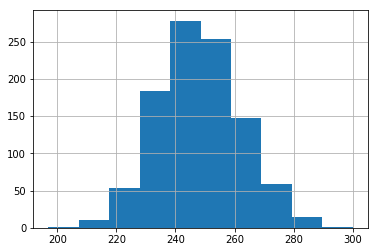

In [483]:
perm_df_long.groupby('SVTYPE_Freq').get_group('DEL_common').contains_exon.hist()

In [1096]:
CM.save_dataframe('perm_df_genic_elements_long', perm_df_long_all, private_out)

perm_df_genic_elements_long = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/perm_df_genic_elements_long.pkl')
perm_df_genic_elements_long = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/perm_df_genic_elements_long.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [486]:
CM.save_dataframe('observed_df_genic_elements', df_observed, private_out)

observed_df_genic_elements = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.pkl')
observed_df_genic_elements = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


# Perform PhyloP calculations in Parallel

In [27]:
dview.push(dict(get_phylop_conservation=get_phylop_conservation, 
                get_phylop_for_seed=get_phylop_for_seed,
               prep_df_phylop = prep_df_phylop,
                compute_phylop_per_category = compute_phylop_per_category));

In [915]:
permutations = range(1, 101)

In [916]:
phylop_perm_dfs1 = dview.map_sync(lambda x: get_phylop_for_seed(x), permutations)

In [922]:
phylop_perm_dfs1 = pd.concat(phylop_perm_dfs1)

In [924]:
CM.save_dataframe('phylop_perm_dfs1', phylop_perm_dfs1, private_out)

phylop_perm_dfs1 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_dfs1.pkl')
phylop_perm_dfs1 = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_dfs1.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [1097]:
permutations = range(101, 1001)

In [941]:
# this will actually take a while- so lets use async
phylop_perm_dfs_other = dview.map_async(lambda x: get_phylop_for_seed(x), permutations)

In [983]:
phylop_perm_dfs_other = pd.concat(phylop_perm_dfs_other)

In [1051]:
phylop_perm_all = pd.concat([phylop_perm_dfs1, phylop_perm_dfs_other])

In [1052]:
phylop_perm_all['SVTYPE_Freq'] = phylop_perm_all.index

In [990]:
CM.save_dataframe('phylop_perm_all', phylop_perm_all, private_out)

phylop_perm_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_all.pkl')
phylop_perm_all = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_all.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [53]:
phylop_perm_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_all.pkl')

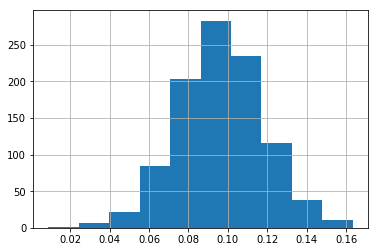

In [55]:
phylop_perm_all.groupby('SVTYPE_Freq').get_group('ALU_common')['mean_phylop'].hist()

In [28]:
permutations = range(1001, 5001)
phylop_perm_dfs_other2 = dview.map_async(lambda x: get_phylop_for_seed(x), permutations)

# Read back in permutation output 

In [126]:
def prep_df_phylo_out(df):
    df = df.copy()
    df['SVTYPE_Freq'] = df.index
    return df
    

In [139]:
out_fns = glob.glob('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/out_stats_phylo/*.stat')

In [141]:
phylo_perm_dfs = []
for f in out_fns:
    df = pd.read_table(f, index_col=0)
    phylo_perm_dfs.append(df)

In [142]:
phylo_perm_4k = pd.concat(phylo_perm_dfs)
phylo_perm_4k = phylo_perm_4k.pipe(prep_df_phylo_out)

In [124]:
phylop_perm_1k = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_all.pkl')

In [143]:
phylo_perm_5k = pd.concat([phylop_perm_1k, phylo_perm_4k])

In [150]:
CM.save_dataframe('phylop_perm_5k', phylo_perm_5k, private_out)

phylop_perm_5k = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_5k.pkl')
phylop_perm_5k = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_perm_5k.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


# Compute Z scores for Genetic Intersect Categories

In [215]:
perm_df_genic_elements_long = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/perm_df_genic_elements_long.pkl')

df_observed =  pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.pkl')

perm_df_long = perm_df_genic_elements_long

perm_mean = perm_df_long.groupby('SVTYPE_Freq').mean()
perm_sd = perm_df_long.groupby('SVTYPE_Freq').std()
cols = 'contains_exon	contains_gene	intersects_exon	intersects_intron	intersects_promoter	intergenic'.split()

In [216]:
signif_thresh = 0.05/29

zscore_thresh = (0.05/2)*(1/29)

signif_z = abs(stats.norm.ppf(zscore_thresh))

In [217]:
df_observed_z = df_observed.copy()
df_observed_p = df_observed.copy()
for c in cols:
    mean = perm_mean[c]
    sd = perm_sd[c]
    obs = df_observed[c]
    
    col_name_out_z = "{}_Z".format(c)
    col_name_out_p = "{}_p".format(c)
    
    z_score = (obs - mean)/ sd
    df_observed_z[c] = z_score
    z_score = z_score.fillna(0)
    
    p_values = z_score.apply(lambda x: stats.norm.sf(abs(x))*2)
    
    df_observed_z[c] = z_score
    df_observed_p[c] = p_values 
    df_observed[col_name_out_z] = z_score 
    df_observed[col_name_out_p] = p_values
   

In [218]:
def prep_df_observed(df):
    df = df.copy()
    df = df.fillna(0)
    df['SVTYPE_Freq'] = df.index
    df['SVTYPE'] = df.SVTYPE_Freq.apply(lambda x: x.split('_')[0])
    df['Frequency'] = df.SVTYPE_Freq.apply(lambda x: x.split('_')[1])
    return df

In [219]:
df_observed = df_observed.pipe(prep_df_observed)
df_observed_z = df_observed_z.pipe(prep_df_observed)

In [220]:
cols = 'contains_exon	contains_gene	intersects_exon	intersects_intron	intersects_promoter	intergenic'.split()
for_plot = pd.melt(df_observed_z, id_vars=['SVTYPE', 'Frequency'], value_vars= cols).fillna(0)

In [221]:

var_classes_all = ['DEL', 'DUP','mCNV', 'BND', 'INV', 'rMEI','LINE1', 'ALU', 'SVA', 'STR']
order_freq = ['common', 'rare', 'singleton']

cols = 'contains_exon	contains_gene	intersects_exon	intersects_intron	intersects_promoter	intergenic'.split()
order_dict = dict(zip(['common', 'rare', 'singleton', 'gap'], range(4)))
order_dict_svtype = dict(zip(var_classes_all, range(len(var_classes_all))))


for_plot['order_freq'] = for_plot.Frequency.apply(lambda x: order_dict[x])
for_plot['order_svtype'] = for_plot.SVTYPE.apply(lambda x: order_dict_svtype[x])
for_plot = for_plot.sort_values(['variable', 'order_svtype', 'order_freq'])
# tick_labels = for_plot_gapped.index.tolist()
# tick_labels_mod = [i if i.split('_')[1] != 'gap' else '' for i in tick_labels]

In [222]:
cols = 'contains_exon	contains_gene	intersects_exon	intersects_intron	intersects_promoter	intergenic'.split()
df_observed['total_sv'] = df_observed[cols].sum(axis = 1)

In [231]:
dfs = []
for c in cols:
    name_out = "{}_FC".format(c)
    perm_mean_c = perm_mean[c]
    
    
    diff = (df_observed[c] - perm_mean_c) 
    dfs.append(diff.to_frame(c))
    
    FC = diff/perm_mean_c
    df_observed[name_out] = FC
    

In [108]:
for c in cols:
    name_out = "{}_log2".format(c)
    perm_mean_c = perm_mean[c]
    df_observed[name_out] = np.log2((df_observed[c] + 1 /df_observed.total_sv)  / (perm_mean_c +1 / df_observed.total_sv))

In [110]:
cols = 'contains_exon_log2	contains_gene_log2	intersects_exon_log2	intersects_intron_log2	intersects_promoter_log2	intergenic_log2'.split()

In [240]:
CM.save_dataframe('observed_df_genic_elements', df_observed, private_out)

observed_df_genic_elements = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.pkl')
observed_df_genic_elements = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [241]:
CM.save_dataframe('genetic_elements_p', df_observed_p, private_out)

genetic_elements_p = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/genetic_elements_p.pkl')
genetic_elements_p = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/genetic_elements_p.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [242]:
CM.save_dataframe('observed_genic_elements_z', df_observed_z, private_out)

observed_genic_elements_z = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_genic_elements_z.pkl')
observed_genic_elements_z = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_genic_elements_z.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [1111]:
CM.save_dataframe('genic_elements_z_plot', for_plot, private_out)

genic_elements_z_plot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/genic_elements_z_plot.pkl')
genic_elements_z_plot = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/genic_elements_z_plot.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [38]:

observed_df_genic_elements = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_df_genic_elements.pkl')

# Compute Z scores PhyloP

In [151]:
def get_z_scores_and_pvals(df_observed, c, perm_mean, perm_sd):
    df_observed_z = df_observed.copy()
    df_observed_p = df_observed.copy()
    mean = perm_mean
    sd = perm_sd
    obs = df_observed[c]
    
    col_name_out = "{}_Z".format(c)
    col_name_out_p = "{}_p".format(c)

    z_score = (obs - mean)/ sd
    df_observed_z[c] = z_score
    z_score = z_score.fillna(0)
    p_values = z_score.apply(lambda x: stats.norm.sf(abs(x))*2)

    df_observed_z[c] = z_score
    df_observed_p[c] = p_values 
    df_observed[col_name_out] = z_score 
    df_observed[col_name_out_p] = p_values
    return df_observed, df_observed_p, df_observed_z


In [152]:
def prep_for_plot(df_observed_z, cols):
    df_observed_z = df_observed_z.pipe(prep_df_observed)
    
    for_plot = pd.melt(df_observed_z, id_vars=['SVTYPE', 'Frequency', 'SVTYPE_Freq'], value_vars= cols).fillna(0)
    var_classes_all = ['DEL', 'DUP','mCNV', 'BND', 'INV', 'rMEI','LINE1', 'ALU', 'SVA', 'STR']
    order_freq = ['common', 'rare', 'singleton']
    order_dict = dict(zip(['common', 'rare', 'singleton', 'gap'], range(4)))
    order_dict_svtype = dict(zip(var_classes_all, range(len(var_classes_all))))


    for_plot['order_freq'] = for_plot.Frequency.apply(lambda x: order_dict[x])
    for_plot['order_svtype'] = for_plot.SVTYPE.apply(lambda x: order_dict_svtype[x])
    for_plot = for_plot.sort_values(['variable', 'order_svtype', 'order_freq'])
    return for_plot

In [154]:
perm_mean = phylo_perm_5k.groupby('SVTYPE_Freq').mean_phylop.mean()
perm_sd = phylo_perm_5k.groupby('SVTYPE_Freq').mean_phylop.std()

signif_thresh = 0.05/29
zscore_thresh = (0.05/2)*(1/29)
signif_z = abs(stats.norm.ppf(zscore_thresh))

In [189]:
conv = {True:1, False:-1}

In [190]:
observed_phylop['up_or_down'] = observed_phylop.FC.apply(lambda x: conv[(x > 0)])

In [192]:
observed_phylop['log2FC'] = np.log2(np.abs(observed_phylop.FC))

In [193]:
observed_phylop['log2FC'] = observed_phylop['log2FC'] * observed_phylop.up_or_down

In [185]:
np.log2(-0.18)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log2
  if __name__ == '__main__':


nan

In [155]:
observed_phylop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.pkl')

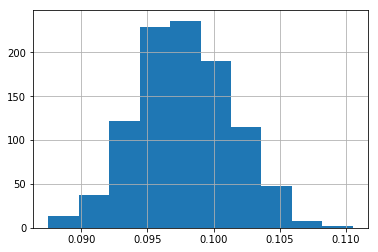

In [1048]:
phylop_perm_all.groupby('SVTYPE_Freq').get_group('DEL_singleton').mean_phylop.hist()

In [156]:
observed_phylop['SVTYPE_Freq'] = observed_phylop.index

In [157]:
observed_phylop = observed_phylop.pipe(prep_df_observed)

In [158]:
observed_phylop, phylop_p, phylop_z = get_z_scores_and_pvals(observed_phylop, 'mean_phylop', perm_mean, perm_sd)

In [159]:
phylop_z['perm_mean'] = perm_mean

In [160]:
observed_phylop['perm_mean']= perm_mean
observed_phylop['perm_sd'] = perm_sd

In [161]:
observed_phylop['diff'] = observed_phylop['mean_phylop'] - observed_phylop['perm_mean']

In [162]:
observed_phylop['Z'] = observed_phylop['diff'] / observed_phylop['perm_sd']

In [169]:
observed_phylop['FC'] = observed_phylop['diff']/observed_phylop.perm_mean

In [174]:
observed_phylop['log2FC'] = np.log2(observed_phylop.FC)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log2
  if __name__ == '__main__':


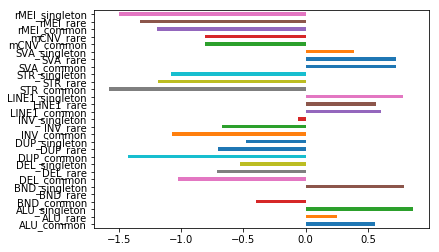

In [207]:
observed_phylop[~observed_phylop.SVTYPE.isin([])]['FC'].plot(kind = 'barh')

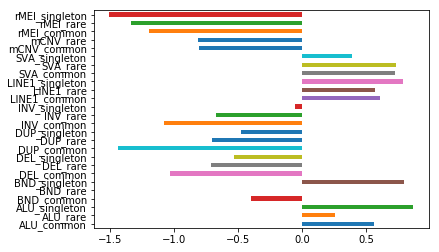

In [201]:
observed_phylop[observed_phylop.SVTYPE !='STR']['FC'].plot(kind = 'barh')

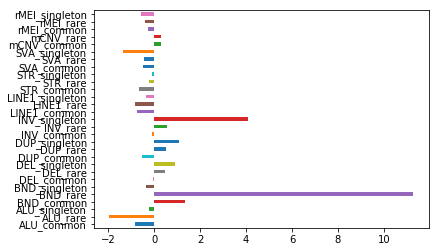

In [196]:
observed_phylop['log2FC'].plot(kind = 'barh')

In [199]:
CM.save_dataframe('phylop_summary', observed_phylop, private_out)

phylop_summary = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_summary.pkl')
phylop_summary = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_summary.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [1082]:
CM.save_dataframe('phylop_z_1000perm', phylop_z, private_out)

phylop_z_1000perm = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_z_1000perm.pkl')
phylop_z_1000perm = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/phylop_z_1000perm.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py


In [1085]:
CM.save_dataframe('observed_phylop', observed_phylop, private_out)

observed_phylop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.pkl')
observed_phylop = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/observed_phylop.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/enrichment_shuffle_svs/load_pickled_nb_variables.py
